# Get performance metrics of the task of generating abstract given text with baseline, zero shot classification and fine tuned on arxiv

In [ ]:
from datasets import load_dataset_builder, get_dataset_config_names, load_dataset, get_dataset_split_names
import psutil
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
from datasets import load_metric
import pandas as pd
from transformers import pipeline

In [ ]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lorenzogermini/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
configs = get_dataset_config_names("scitldr")
print(configs)

['Abstract', 'AIC', 'FullText']


## Abstract section only of scitldr.

In [ ]:
dataset_builder = load_dataset_builder('scitldr', 'Abstract')

Using the AIC is still too long apparently for most of the texts and will cut significantly pieces of texts. Still have also some baselines for those.

In [ ]:
ab = load_dataset('scitldr', 'Abstract', split='test')

Reusing dataset scitldr (/Users/lorenzogermini/.cache/huggingface/datasets/scitldr/Abstract/0.0.0/79e0fa75961392034484808cfcc8f37deb15ceda153b798c92d9f621d1042fef)


Some analysis of og data

In [ ]:
def compute_n_summ(x):
    return {"n_summ": len(x['target'])}

In [ ]:
ab = ab.map(compute_n_summ)

Loading cached processed dataset at /Users/lorenzogermini/.cache/huggingface/datasets/scitldr/Abstract/0.0.0/79e0fa75961392034484808cfcc8f37deb15ceda153b798c92d9f621d1042fef/cache-157088b006b0aa3c.arrow


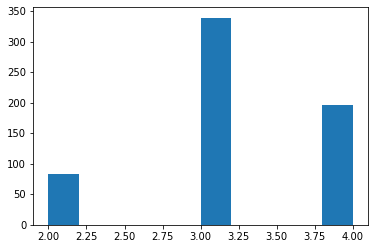

In [ ]:
plt.hist(ab['n_summ']);

Merge all strings in source into one big string to be given in input to the model.

In [ ]:
' '.join(ab['source'][0])

'Incremental class learning involves sequentially learning classes in bursts of examples from the same class. This violates the assumptions that underlie  methods for training standard deep neural networks, and will cause them to suffer from catastrophic forgetting. Arguably, the best method for incremental class learning is iCaRL, but it requires storing  training examples for each class, making it challenging to scale. Here, we propose FearNet for incremental class learning. FearNet is a generative model that does not store previous examples, making it memory efficient. FearNet uses a brain-inspired dual-memory system in which new memories are consolidated from a network for recent memories inspired by the mammalian hippocampal complex to a network for long-term storage inspired by medial prefrontal cortex. Memory consolidation is inspired by mechanisms that occur during sleep. FearNet also uses a module inspired by the basolateral amygdala for determining which memory system to use 

In [ ]:
def merge_strs(x):
  x['source'] = ' '.join(x['source'])
  return x

In [ ]:
ab = ab.map(merge_strs)

Loading cached processed dataset at /Users/lorenzogermini/.cache/huggingface/datasets/scitldr/Abstract/0.0.0/79e0fa75961392034484808cfcc8f37deb15ceda153b798c92d9f621d1042fef/cache-8570bbc2ba7a68bf.arrow


In [ ]:
ab['source'][0]

'Incremental class learning involves sequentially learning classes in bursts of examples from the same class. This violates the assumptions that underlie  methods for training standard deep neural networks, and will cause them to suffer from catastrophic forgetting. Arguably, the best method for incremental class learning is iCaRL, but it requires storing  training examples for each class, making it challenging to scale. Here, we propose FearNet for incremental class learning. FearNet is a generative model that does not store previous examples, making it memory efficient. FearNet uses a brain-inspired dual-memory system in which new memories are consolidated from a network for recent memories inspired by the mammalian hippocampal complex to a network for long-term storage inspired by medial prefrontal cortex. Memory consolidation is inspired by mechanisms that occur during sleep. FearNet also uses a module inspired by the basolateral amygdala for determining which memory system to use 

could like remove all the unused columns to be tidy and reduce memory occupied by dataset.

In [ ]:
ab = ab.remove_columns(['source_labels', 'rouge_scores'])

Insights into tokens length distribution for aic full texts.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-xsum-12-6")

model = AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-xsum-12-6")

In [ ]:
def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["source"]
    ) #not truncate to see tokens distribution
    return model_inputs

In [ ]:
ab = ab.map(preprocess_function, batched=True)

Loading cached processed dataset at /Users/lorenzogermini/.cache/huggingface/datasets/scitldr/Abstract/0.0.0/79e0fa75961392034484808cfcc8f37deb15ceda153b798c92d9f621d1042fef/cache-6e9b0a949e2c07a8.arrow


In [ ]:
def compute_tok_length(example):
    return {"n_tokens": len(example["input_ids"])}

In [ ]:
ab = ab.map(compute_tok_length)

Loading cached processed dataset at /Users/lorenzogermini/.cache/huggingface/datasets/scitldr/Abstract/0.0.0/79e0fa75961392034484808cfcc8f37deb15ceda153b798c92d9f621d1042fef/cache-6132941e61a46d10.arrow


In [ ]:
ab.sort('n_tokens', reverse=True)[:10]['n_tokens']

Loading cached sorted indices for dataset at /Users/lorenzogermini/.cache/huggingface/datasets/scitldr/Abstract/0.0.0/79e0fa75961392034484808cfcc8f37deb15ceda153b798c92d9f621d1042fef/cache-843d04c345b65470.arrow


[443, 432, 396, 396, 383, 382, 382, 380, 377, 368]

In [ ]:
ab.sort('n_tokens', reverse=False)[:10]['n_tokens']

Loading cached sorted indices for dataset at /Users/lorenzogermini/.cache/huggingface/datasets/scitldr/Abstract/0.0.0/79e0fa75961392034484808cfcc8f37deb15ceda153b798c92d9f621d1042fef/cache-d03127fd29e00b73.arrow


[70, 70, 75, 76, 78, 84, 93, 98, 100, 100]

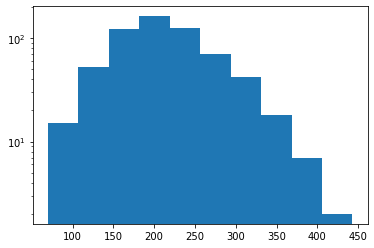

In [ ]:
plt.hist(ab['n_tokens'], log=True);

All the examples are significantly lower than 1024 input tokens.

In [ ]:
#creating baseline only 1st sentence
def one_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:1])

print(one_sentence_summary(ab['source'][0]))

Incremental class learning involves sequentially learning classes in bursts of examples from the same class.


In [ ]:
#creating baseline only first 25 words
def twenty_words_summary(text):
    return " ".join(word_tokenize(text)[:25])

print(twenty_words_summary(ab1['source'][0]))

Incremental class learning involves sequentially learning classes in bursts of examples from the same class . This violates the assumptions that underlie methods for training


Rerun baseline but not with 3 sentence summary as it is basically all the abstract, have to stay within 30-40 ish tokens.

Random baseline with no ML could also be text generation with HMMs chains. Given that abstract is not super long could be a more realistic task.

In [ ]:
rouge_score = load_metric("rouge")

Evaluate baseline for summarization.

In [ ]:
def sel_sum(x):
  x['target'] = x['target'][0]
  return x

In [ ]:
ab1 = ab.map(sel_sum)

  0%|          | 0/618 [00:00<?, ?ex/s]

In [ ]:
def sel_sum2(x):
  x['target'] = x['target'][1]
  return x

In [ ]:
ab2=ab.map(sel_sum2)

  0%|          | 0/618 [00:00<?, ?ex/s]

In [ ]:
ab2['target'][0]

'This paper presents a novel solution to an incremental classification problem based on a dual memory system. '

In [ ]:
del ab

In [ ]:
def evaluate_baseline1(dataset, metric):
    summaries = [one_sentence_summary(text) for text in dataset['source']]
    return metric.compute(predictions=summaries, references=dataset['target'])

score = evaluate_baseline1(pubmed, rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

### Baseline first sentence evaluation.

With respect to first summary.

In [ ]:
score = evaluate_baseline1(ab1, rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 22.93, 'rouge2': 8.57, 'rougeL': 18.35, 'rougeLsum': 18.51}

With respect to second summary.

In [ ]:
score = evaluate_baseline1(ab2, rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 18.07, 'rouge2': 3.49, 'rougeL': 14.05, 'rougeLsum': 14.08}

We can see that the rouge2 score is significantly lower than the rest; this likely reflects the fact that review titles are typically concise and so the lead-3 baseline is too verbose.

Quite different results between the two (check significance), just need to get sign from rouge computation results.

### Baseline evaluation with only first 20 words (avg words length for target summaries) (more precise given that we have control over total number of words and thus more relatable to the machine generated summaries.

In [ ]:
def evaluate_baseline2(dataset, metric):
    summaries = [twenty_words_summary(text) for text in dataset['source']]
    return metric.compute(predictions=summaries, references=dataset['target'])

With respect to first summary.

In [ ]:
score = evaluate_baseline2(ab1, rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 23.05, 'rouge2': 8.31, 'rougeL': 17.96, 'rougeLsum': 17.99}

With respect to second summary.

In [ ]:
score = evaluate_baseline2(ab2, rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 18.85, 'rouge2': 3.55, 'rougeL': 14.4, 'rougeLsum': 14.39}

Evaluate zero shot summarization with distilbart finetuned on xsum given amount of summarization.

In [ ]:
summarizer = pipeline("summarization", model='sshleifer/distilbart-xsum-12-6')

Have to check better what beams mean and also gpu stuff.

In [ ]:
def evaluate_zeroshot(dataset, metric): #removed top 50 k
    summaries = [summarizer(text, min_length=20, max_length=35, num_beams=10, early_stopping=True, clean_up_tokenization_spaces=True)[0]['summary_text'] for text in dataset['source']]
    return metric.compute(predictions=summaries, references=dataset['target'])

In [ ]:
score = evaluate_zeroshot(ab1, rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 22.23, 'rouge2': 5.92, 'rougeL': 17.79, 'rougeLsum': 17.78}

In [ ]:
score = evaluate_zeroshot(ab2, rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 20.22, 'rouge2': 3.03, 'rougeL': 15.62, 'rougeLsum': 15.6}

#### This one was done with old measures and error of always including summary error thingy, rouge1 improved by 2 and both rougeL and Lsum by 1.

In [ ]:
#score = evaluate_zeroshot(ab1, rouge_score)
#rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
#rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
#rouge_dict

{'rouge1': 20.71, 'rouge2': 5.37, 'rougeL': 16.68, 'rougeLsum': 16.68}

20 mins to run on cpu.

In [ ]:
#score = evaluate_zeroshot(ab2, rouge_score)
#rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
#rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
#rouge_dict

{'rouge1': 18.4, 'rouge2': 2.64, 'rougeL': 14.49, 'rougeLsum': 14.5}

Test with different machine generated summaries from different models, just to see which one looks better (abstract from fermented food sonnenburg).

In [ ]:
tex = 'Diet modulates the gut microbiome, which in turn can impact the immune system. Here, we determined how two microbiota-targeted dietary interventions, plant-based fiber and fermented foods, influence the human microbiome and immune system in healthy adults. Using a 17-week randomized, prospective study (n = 18/arm) combined with -omics measurements of microbiome and host, including extensive immune profiling, we found diet-specific effects. The high-fiber diet increased microbiome-encoded glycan-degrading carbohydrate active enzymes (CAZymes) despite stable microbial community diversity. Although cytokine response score (primary outcome) was unchanged, three distinct immunological trajectories in high-fiber consumers corresponded to baseline microbiota diversity. Alternatively, the high-fermented-food diet steadily increased microbiota diversity and decreased inflammatory markers. The data highlight how coupling dietary interventions to deep and longitudinal immune and microbiome profiling can provide individualized and population-wide insight. Fermented foods may be valuable in countering the decreased microbiome diversity and increased inflammation pervasive in industrialized society.'

In [ ]:
tldr_pap = 'The foods you eat can change the bacteria in your body. These bacteria can help or hurt your immune system.The people who ate the most fermented foods had the most diverse kinds of bacteria and the lowest levels of inflammation.'

In [ ]:
distil_xsum = summarizer(tex, min_length=20, max_length=50, num_beams=10, early_stopping=True, clean_up_tokenization_spaces=True)[0]['summary_text']

In [ ]:
distil_xsum

' A high-fiber diet can increase the diversity of the human gut and reduce inflammation, a study suggests.'

### Used fine tuned version of catts allenai model (the one which was generated with this dataset to evaluate performance on test set.


In [ ]:
summarizer = pipeline('summarization', model='lrakotoson/scitldr-catts-xsum-ao')

In [ ]:
scitldr_sum = summarizer(tex, min_length=20, max_length=35, num_beams=10, early_stopping=True, clean_up_tokenization_spaces=True)[0]['summary_text']

In [ ]:
scitldr_sum

'High-Fiber Diet and Fermented Foods Influence Microbiome Diversity and Immune System in Healthy Adults.'

In [ ]:
def evaluate_zeroshot1(dataset, metric): #removed top 50 k
    summaries = [summarizer(text, min_length=20, max_length=35, num_beams=10, early_stopping=True, clean_up_tokenization_spaces=True)[0]['summary_text'] for text in dataset['source']]
    return metric.compute(predictions=summaries, references=dataset['target'])

In [ ]:
score = evaluate_zeroshot1(ab1, rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 29.6, 'rouge2': 13.07, 'rougeL': 24.35, 'rougeLsum': 24.32}

In [ ]:
score = evaluate_zeroshot1(ab2, rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 21.51, 'rouge2': 5.96, 'rougeL': 16.92, 'rougeLsum': 16.91}

In [ ]:
allenai_semantic_search = 'The data highlight how coupling dietary interventions to deep and longitudinal immune and microbiome profiling can provide individualized and population-wide insight and indicate that fermented foods may be valuable in countering the decreased microbiome diversity and increased inflammation pervasive in the industrialized society.'

Big bird pegasus (can handle up to 4096 tokens) fine tuned on pubmed.

In [ ]:
summarizer = pipeline('summarization', model='google/bigbird-pegasus-large-pubmed')

Downloading:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.35M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/775 [00:00<?, ?B/s]

In [ ]:
%%timeit
summarizer(tex, min_length=20, max_length=40, num_beams=6, early_stopping=True, clean_up_tokenization_spaces=True)[0]['summary_text']

4.66 s ± 64.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
big_birdsum

'the human microbiome is an integral part of the human immune system, yet little is known about how this microorganism influences host health. in a prospective 18-week randomized controlled trial, we determined the effects of a highfiber diet and'

Seems to not work super well with generating extremely short summaries

In [ ]:
big_birdsum

'the human microbiome is an integral part of the human immune system, yet little is known about how this microorganism influences host health. in a prospective 18-week randomized controlled trial, we determined the effects of a highfiber diet and'

Seems to not work super well for very short generated summaries. Still check with ab1 how it performs.

In [ ]:
def evaluate_zeroshot1(dataset, dataset2, metric): #removed top 50 k
    summaries = [summarizer(text, min_length=20, max_length=40, num_beams=10, early_stopping=True, clean_up_tokenization_spaces=True)[0]['summary_text'] for text in dataset['source']]
    return metric.compute(predictions=summaries, references=dataset['target']), metric.compute(predictions=summaries, references=dataset2['target'])

In [ ]:
score1, score2 = evaluate_zeroshot1(ab1[1:10], ab2[1:10], rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict1 = dict((rn, round(score1[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
print(rouge_dict1)
rouge_dict2 = dict((rn, round(score2[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict2

{'rouge1': 19.55, 'rouge2': 5.96, 'rougeL': 15.37, 'rougeLsum': 15.62}


{'rouge1': 14.94, 'rouge2': 1.96, 'rougeL': 12.74, 'rougeLsum': 12.75}

Big bird pegasus seems to significantly struggle with this kind of dataset, maybe needs more data? Let's try it out with the AIC dataset in the next round.

In [ ]:
import torch
if torch.backends.mps.is_available():
    device = torch.device("mps")
print(torch.backends.mps.is_built())
# And that the current hardware and MacOS version are sufficient to
# be able to use MPS
print(torch.backends.mps.is_available())

True
True


## AIC test split of scitldr.

Using the AIC is still too long apparently for most of the of the summarization models (>> 1024 tokens but big bird pegasus can handle it) and will cut significantly pieces of texts.

In [ ]:
aic = load_dataset('scitldr', 'AIC', split='test')

Reusing dataset scitldr (/Users/lorenzogermini/.cache/huggingface/datasets/scitldr/AIC/0.0.0/79e0fa75961392034484808cfcc8f37deb15ceda153b798c92d9f621d1042fef)


Some analysis of og data

In [ ]:
def compute_n_summ(x):
    return {"n_summ": len(x['target'])}

In [ ]:
aic = aic.map(compute_n_summ)

Loading cached processed dataset at /Users/lorenzogermini/.cache/huggingface/datasets/scitldr/AIC/0.0.0/79e0fa75961392034484808cfcc8f37deb15ceda153b798c92d9f621d1042fef/cache-8761990cf6080808.arrow


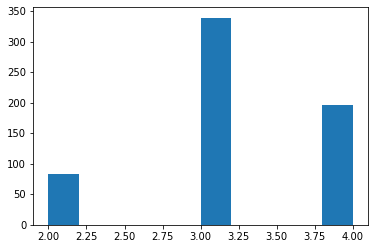

In [ ]:
plt.hist(aic['n_summ']);

Merge all strings in source into one big string to be given in input to the model.

In [ ]:
' '.join(aic['source'][0])

'Incremental class learning involves sequentially learning classes in bursts of examples from the same class. This violates the assumptions that underlie  methods for training standard deep neural networks, and will cause them to suffer from catastrophic forgetting. Arguably, the best method for incremental class learning is iCaRL, but it requires storing  training examples for each class, making it challenging to scale. Here, we propose FearNet for incremental class learning. FearNet is a generative model that does not store previous examples, making it memory efficient. FearNet uses a brain-inspired dual-memory system in which new memories are consolidated from a network for recent memories inspired by the mammalian hippocampal complex to a network for long-term storage inspired by medial prefrontal cortex. Memory consolidation is inspired by mechanisms that occur during sleep. FearNet also uses a module inspired by the basolateral amygdala for determining which memory system to use 

In [ ]:
def merge_strs(x):
  x['source'] = ' '.join(x['source'])
  return x

In [ ]:
aic = aic.map(merge_strs)

Loading cached processed dataset at /Users/lorenzogermini/.cache/huggingface/datasets/scitldr/AIC/0.0.0/79e0fa75961392034484808cfcc8f37deb15ceda153b798c92d9f621d1042fef/cache-dfa31ad84593b5a2.arrow


In [ ]:
aic['source'][0]

'Incremental class learning involves sequentially learning classes in bursts of examples from the same class. This violates the assumptions that underlie  methods for training standard deep neural networks, and will cause them to suffer from catastrophic forgetting. Arguably, the best method for incremental class learning is iCaRL, but it requires storing  training examples for each class, making it challenging to scale. Here, we propose FearNet for incremental class learning. FearNet is a generative model that does not store previous examples, making it memory efficient. FearNet uses a brain-inspired dual-memory system in which new memories are consolidated from a network for recent memories inspired by the mammalian hippocampal complex to a network for long-term storage inspired by medial prefrontal cortex. Memory consolidation is inspired by mechanisms that occur during sleep. FearNet also uses a module inspired by the basolateral amygdala for determining which memory system to use 

could like remove all the unused columns to be tidy and reduce memory occupied by dataset.

In [ ]:
aic = aic.remove_columns(['source_labels', 'rouge_scores'])

Insights into tokens length distribution for aic full texts with google bigbird pegasus tokenizer.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("google/bigbird-pegasus-large-pubmed")

In [ ]:
def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["source"]
    ) #not truncate to see tokens distribution
    return model_inputs

In [ ]:
aic = aic.map(preprocess_function, batched=True)

Loading cached processed dataset at /Users/lorenzogermini/.cache/huggingface/datasets/scitldr/AIC/0.0.0/79e0fa75961392034484808cfcc8f37deb15ceda153b798c92d9f621d1042fef/cache-33455dc6a8c5715a.arrow


In [ ]:
def compute_tok_length(example):
    return {"n_tokens": len(example["input_ids"])}

In [ ]:
aic = aic.map(compute_tok_length)

Loading cached processed dataset at /Users/lorenzogermini/.cache/huggingface/datasets/scitldr/AIC/0.0.0/79e0fa75961392034484808cfcc8f37deb15ceda153b798c92d9f621d1042fef/cache-589d50caec8b688d.arrow


In [ ]:
aic.sort('n_tokens', reverse=True)[:10]['n_tokens']

Loading cached sorted indices for dataset at /Users/lorenzogermini/.cache/huggingface/datasets/scitldr/AIC/0.0.0/79e0fa75961392034484808cfcc8f37deb15ceda153b798c92d9f621d1042fef/cache-20e2a9ccc9b6b29f.arrow


[3994, 3598, 3557, 3473, 3322, 3255, 3173, 2812, 2712, 2671]

In [ ]:
aic.sort('n_tokens', reverse=False)[:10]['n_tokens']

Loading cached sorted indices for dataset at /Users/lorenzogermini/.cache/huggingface/datasets/scitldr/AIC/0.0.0/79e0fa75961392034484808cfcc8f37deb15ceda153b798c92d9f621d1042fef/cache-0598d5b3e1d08f8f.arrow


[128, 167, 168, 170, 174, 176, 178, 182, 192, 204]

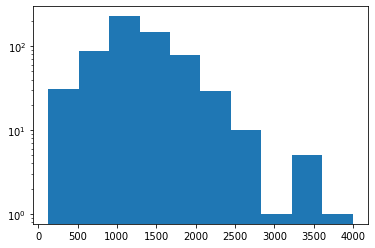

In [ ]:
plt.hist(aic['n_tokens'], log=True);

Filter out examples with more than 2500 words.

In [ ]:
aic.filter(lambda x: x["n_tokens"] > 2500).num_rows

Loading cached processed dataset at /Users/lorenzogermini/.cache/huggingface/datasets/scitldr/AIC/0.0.0/79e0fa75961392034484808cfcc8f37deb15ceda153b798c92d9f621d1042fef/cache-43ac02cf3a3fa6c6.arrow


14

In [ ]:
aic = aic.filter(lambda x: x["n_tokens"] <= 2500)

Loading cached processed dataset at /Users/lorenzogermini/.cache/huggingface/datasets/scitldr/AIC/0.0.0/79e0fa75961392034484808cfcc8f37deb15ceda153b798c92d9f621d1042fef/cache-1d802f3b78ee11c0.arrow


All the examples are significantly lower than 1024 input tokens.

In [ ]:
#creating baseline only 1st sentence
def one_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:1])

print(one_sentence_summary(aic['source'][0]))

Incremental class learning involves sequentially learning classes in bursts of examples from the same class.


In [ ]:
#creating baseline only first 25 words
def twenty_words_summary(text):
    return " ".join(word_tokenize(text)[:35])

print(twenty_words_summary(aic['source'][0]))

Incremental class learning involves sequentially learning classes in bursts of examples from the same class . This violates the assumptions that underlie methods for training standard deep neural networks , and will cause them to


Rerun baseline but not with 3 sentence summary as it is basically all the abstract, have to stay within 30-40 ish tokens.

Random baseline with no ML could also be text generation with HMMs chains. Given that abstract is not super long could be a more realistic task.

In [ ]:
rouge_score = load_metric("rouge")

Evaluate baseline for summarization.

In [ ]:
def sel_sum(x):
  x['target'] = x['target'][0]
  return x

In [ ]:
aic1 = aic.map(sel_sum)

Loading cached processed dataset at /Users/lorenzogermini/.cache/huggingface/datasets/scitldr/AIC/0.0.0/79e0fa75961392034484808cfcc8f37deb15ceda153b798c92d9f621d1042fef/cache-969af61eaa94f430.arrow


In [ ]:
def sel_sum2(x):
  x['target'] = x['target'][1]
  return x

In [ ]:
aic2=aic.map(sel_sum2)

Loading cached processed dataset at /Users/lorenzogermini/.cache/huggingface/datasets/scitldr/AIC/0.0.0/79e0fa75961392034484808cfcc8f37deb15ceda153b798c92d9f621d1042fef/cache-87ed1216843f5f5e.arrow


In [ ]:
aic2['target'][0]

'This paper presents a novel solution to an incremental classification problem based on a dual memory system. '

In [ ]:
del aic

Evaluate baselines.

In [ ]:
def evaluate_baseline1(dataset, dataset2, metric):
    summaries = [twenty_words_summary(text) for text in dataset['source']]
    return metric.compute(predictions=summaries, references=dataset['target']),\
    metric.compute(predictions=summaries, references=dataset2['target'])

In [ ]:
score1, score2 = evaluate_baseline1(aic1, aic2, rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict1 = dict((rn, round(score1[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
print(rouge_dict1)
rouge_dict2 = dict((rn, round(score2[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict2

{'rouge1': 23.59, 'rouge2': 8.43, 'rougeL': 17.94, 'rougeLsum': 17.94}


{'rouge1': 19.46, 'rouge2': 3.52, 'rougeL': 14.19, 'rougeLsum': 14.18}

Evaluate zeroshot summarization with certain

Evaluate with big bird pegasus finetuned on pubmed:

In [ ]:
summarizer = pipeline('summarization', model='google/bigbird-pegasus-large-pubmed')

In [ ]:
def evaluate_bigbird(dataset, dataset2, metric): #removed top 50 k
    summaries = [summarizer(text, min_length=20, max_length=45, num_beams=4,early_stopping=True, clean_up_tokenization_spaces=True)[0]['summary_text'] for text in dataset['source']]
    return metric.compute(predictions=summaries, references=dataset['target']), metric.compute(predictions=summaries, references=dataset2['target'])

In [ ]:
summarizer(aic1['source'][0], min_length=20, max_length=45, num_beams=4,\
                            early_stopping=True, \
                            clean_up_tokenization_spaces=True, skip_special_tokens=True)[0]['summary_text']

'this paper proposes a network architecture for neural networks ( nnn ) based on the pseudocampous model.<n> the nnn is a sequential learning model where each neuron is represented by a set of rules.'

Still summaries seem a bit off, prob with fine tuning on pubmed struggles a bit more to generate very concise summaries.

In [ ]:
score1, score2 = evaluate_bigbird(aic1[1:100], aic2[1:100], rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict1 = dict((rn, round(score1[rn].mid.fmeasure * 100, 2)) for rn in\
                   rouge_names)
print(rouge_dict1)
rouge_dict2 = dict((rn, round(score2[rn].mid.fmeasure * 100, 2)) for rn in\
                   rouge_names)
rouge_dict2

{'rouge1': 16.98, 'rouge2': 2.6, 'rougeL': 13.15, 'rougeLsum': 13.23}


{'rouge1': 17.14, 'rouge2': 2.03, 'rougeL': 13.28, 'rougeLsum': 13.25}

Try to reduce max_length after having succesfully improved performance by reducing n_beams to 4. Big bird fine tuned on pubmed seems to struggle significantly when asked to generate very long summaries.

Try with booksum fine tuned big bird pegasus

### For optimal abstract summary length look at rhonda patrick tweets and tldr length.

Bart struggles with long docs more than 1024 tokens, might look into 

## AIC of scitldr dataset section

In [ ]:
dataset_builder = load_dataset_builder('scitldr', 'AIC')

In [ ]:
print(dataset_builder.info.features)

{'source': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'source_labels': Sequence(feature=ClassLabel(num_classes=2, names=[0, 1], id=None), length=-1, id=None), 'rouge_scores': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), 'paper_id': Value(dtype='string', id=None), 'ic': Value(dtype='bool_', id=None), 'target': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}


In [ ]:
print(dataset_builder.info.splits)

{'train': SplitInfo(name='train', num_bytes=14473794, num_examples=1992, dataset_name='scitldr'), 'test': SplitInfo(name='test', num_bytes=4821998, num_examples=618, dataset_name='scitldr'), 'validation': SplitInfo(name='validation', num_bytes=4476209, num_examples=619, dataset_name='scitldr')}


In [ ]:
print(dataset_builder.cache_dir)

/Users/lorenzogermini/.cache/huggingface/datasets/scitldr/AIC/0.0.0/79e0fa75961392034484808cfcc8f37deb15ceda153b798c92d9f621d1042fef


Using the AIC is still too long apparently for most of the texts and will cut significantly pieces of texts. Still have also some baselines for those.

In [ ]:
tldr_aic = load_dataset('scitldr', 'Abstract', split='test')

Reusing dataset scitldr (/Users/lorenzogermini/.cache/huggingface/datasets/scitldr/Abstract/0.0.0/79e0fa75961392034484808cfcc8f37deb15ceda153b798c92d9f621d1042fef)


Some analysis of og data

In [ ]:
len(tldr_aic['target'][3])

4

In [ ]:
def compute_n_summ(x):
    return {"n_summ": len(x['target'])}

In [ ]:
tldr_aic = tldr_aic.map(compute_n_summ)

  0%|          | 0/618 [00:00<?, ?ex/s]

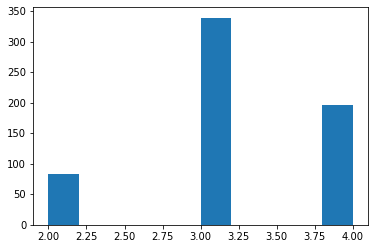

In [ ]:
plt.hist(tldr_aic['n_summ']);

Merge all strings in source into one big string to be given in input to the model.

In [ ]:
' '.join(tldr_aic['source'][0])

'Incremental class learning involves sequentially learning classes in bursts of examples from the same class. This violates the assumptions that underlie  methods for training standard deep neural networks, and will cause them to suffer from catastrophic forgetting. Arguably, the best method for incremental class learning is iCaRL, but it requires storing  training examples for each class, making it challenging to scale. Here, we propose FearNet for incremental class learning. FearNet is a generative model that does not store previous examples, making it memory efficient. FearNet uses a brain-inspired dual-memory system in which new memories are consolidated from a network for recent memories inspired by the mammalian hippocampal complex to a network for long-term storage inspired by medial prefrontal cortex. Memory consolidation is inspired by mechanisms that occur during sleep. FearNet also uses a module inspired by the basolateral amygdala for determining which memory system to use 

In [ ]:
def merge_strs(x):
  x['source'] = ' '.join(x['source'])
  return x

In [ ]:
up_d = tldr_aic.map(merge_strs)

  0%|          | 0/618 [00:00<?, ?ex/s]

In [ ]:
up_d['source'][0]

'Incremental class learning involves sequentially learning classes in bursts of examples from the same class. This violates the assumptions that underlie  methods for training standard deep neural networks, and will cause them to suffer from catastrophic forgetting. Arguably, the best method for incremental class learning is iCaRL, but it requires storing  training examples for each class, making it challenging to scale. Here, we propose FearNet for incremental class learning. FearNet is a generative model that does not store previous examples, making it memory efficient. FearNet uses a brain-inspired dual-memory system in which new memories are consolidated from a network for recent memories inspired by the mammalian hippocampal complex to a network for long-term storage inspired by medial prefrontal cortex. Memory consolidation is inspired by mechanisms that occur during sleep. FearNet also uses a module inspired by the basolateral amygdala for determining which memory system to use 

could like remove all the unused columns to be tidy and reduce memory occupied by dataset.

In [ ]:
#....

Insights into tokens length distribution for aic full texts.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-xsum-12-6")

model = AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-xsum-12-6")

In [ ]:
def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["source"]
    ) #not truncate to see tokens distribution
    return model_inputs

In [ ]:
up_d = up_d.map(preprocess_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
def compute_tok_length(example):
    return {"n_tokens": len(example["input_ids"])}

In [ ]:
up_d = up_d.map(compute_tok_length)

  0%|          | 0/618 [00:00<?, ?ex/s]

In [ ]:
up_d.sort('n_tokens', reverse=True)[:10]['n_tokens']

[443, 432, 396, 396, 383, 382, 382, 380, 377, 368]

In [ ]:
up_d.sort('n_tokens', reverse=False)[:10]['n_tokens']

[70, 70, 75, 76, 78, 84, 93, 98, 100, 100]

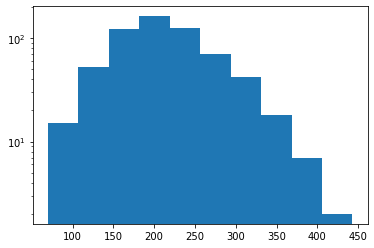

In [ ]:
plt.hist(up_d['n_tokens'], log=True);

We see that even in the AIC we have quite a few input text longer than 1024 tokens. For now let's just filter out the ones more than 2500 words and proceed with the Rouge evaluations.

In [ ]:
#look comment below

In [ ]:
print(up_d.filter(lambda x: x["n_tokens"] > 1000).num_rows) #re run until here for aic dataset, used to be 458 rows (i ran this analysis on the abstract and not aic)

  0%|          | 0/1 [00:00<?, ?ba/s]

0


In [ ]:
gg = up_d.filter(lambda x: x["n_tokens"] > 1000)

Loading cached processed dataset at /Users/lorenzogermini/.cache/huggingface/datasets/scitldr/AIC/0.0.0/79e0fa75961392034484808cfcc8f37deb15ceda153b798c92d9f621d1042fef/cache-36c9c74a9a6c7f05.arrow


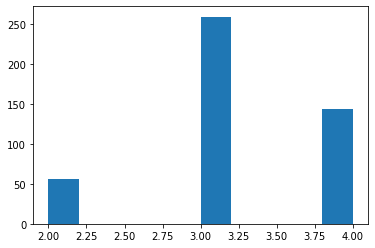

In [ ]:
plt.hist(gg['n_summ']);

In [ ]:
gg = gg.remove_columns(['source_labels', 'rouge_scores', 'ic', 'attention_mask'])

In [ ]:
gg

Dataset({
    features: ['source', 'paper_id', 'target', 'n_summ', 'input_ids', 'n_tokens'],
    num_rows: 458
})

In [ ]:
#creating baseline
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

print(three_sentence_summary(gg['source'][0]))

Incremental class learning involves sequentially learning classes in bursts of examples from the same class.
This violates the assumptions that underlie  methods for training standard deep neural networks, and will cause them to suffer from catastrophic forgetting.
Arguably, the best method for incremental class learning is iCaRL, but it requires storing  training examples for each class, making it challenging to scale.


In [ ]:
rouge_score = load_metric("rouge")

Evaluate baseline for summarization.

In [ ]:
def sel_sum(x):
  x['target'] = x['target'][0]
  return x

In [ ]:
gg1 = gg.map(sel_sum)

  0%|          | 0/458 [00:00<?, ?ex/s]

In [ ]:
def sel_sum2(x):
  x['target'] = x['target'][1]
  return x

In [ ]:
gg2=gg.map(sel_sum2)

  0%|          | 0/458 [00:00<?, ?ex/s]

In [ ]:
gg2['target'][0]

'This paper presents a novel solution to an incremental classification problem based on a dual memory system. '

In [ ]:
def evaluate_baseline(dataset, metric):
    summaries = [three_sentence_summary(text) for text in dataset['source']]
    return metric.compute(predictions=summaries, references=dataset['target'])

Baseline evaluation with respect to first summary.

In [ ]:
import pandas as pd

score = evaluate_baseline(gg1, rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 22.51, 'rouge2': 9.01, 'rougeL': 16.83, 'rougeLsum': 19.37}

Baseline evaluation with respect to second summary.

In [ ]:
import pandas as pd

score = evaluate_baseline(gg2, rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 19.18, 'rouge2': 3.82, 'rougeL': 12.96, 'rougeLsum': 15.32}

Quite different results between the two (check significance), just need to get sign from rouge computation results.

Evaluate zero shot summarization with distilbart finetuned on xsum given amount of summarization.

In [ ]:
from transformers import pipeline
summarizer = pipeline("summarization", model='sshleifer/distilbart-xsum-12-6')

Have to check better what beams mean and also gpu stuff.

In [ ]:
def evaluate_zeroshot(dataset, metric):
    summaries = [summarizer(text, truncation=True, min_length=15, max_length=25, ) for text in dataset['source']]
    return metric.compute(predictions=summaries, references=dataset['target'])

In [ ]:
score = evaluate_zeroshot(gg1, rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 23.86, 'rouge2': 7.42, 'rougeL': 19.32, 'rougeLsum': 19.29}

20 mins to run on cpu.

In [ ]:
score = evaluate_zeroshot(gg2, rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 19.51, 'rouge2': 3.34, 'rougeL': 15.4, 'rougeLsum': 15.41}

Evaluate zeroshot with gpu model with function.

In [ ]:
gg1 = gg1.remove_columns(['input_ids'])

Move everything on gpu.

In [ ]:
def preprocess(examples):
    model_inputs = tokenizer(
        examples["source"], max_length=1024, truncation=True)
    return model_inputs

In [ ]:
gg1_proc = gg1.map(preprocess, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
gg1_proc['input_ids'][0]

In [ ]:
gg1_proc['target'][0]

'FearNet is a memory efficient neural-network, inspired by memory formation in the mammalian brain, that is capable of incremental class learning without catastrophic forgetting.'

In [ ]:
%%timeit
inputs = tokenizer(gg1['source'][0], max_length=1024, truncation=True, return_tensors="pt")
summary_ids = model.generate(inputs['input_ids'], min_length=15, max_length=25) #avg summ length is 20 words
tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

2.61 s ± 15.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
import torch
if torch.backends.mps.is_available():
    device = torch.device("mps")

In [ ]:
device

device(type='mps')

In [ ]:
import torch
if torch.backends.mps.is_available():
    device = torch.device("mps")
print(torch.backends.mps.is_built())
# And that the current hardware and MacOS version are sufficient to
# be able to use MPS
print(torch.backends.mps.is_available())

True
True


In [ ]:
model.to(device)

In [ ]:
inputs = tokenizer(gg1['source'][0], max_length=1024, truncation=True, return_tensors="pt").to(device)

In [ ]:
#%%timeit
#inputs = tokenizer(gg1['source'][0], max_length=1024, truncation=True, return_tensors="pt").to(device)
summary_ids = model.generate(inputs['input_ids'], min_length=15, max_length=25) #avg summ length is 20 words
tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

/Users/lorenzogermini/miniforge3/envs/ml/lib/python3.9/site-packages/transformers/generation_logits_process.py:333: UserWarning: The operator 'aten::_index_put_impl_' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  scores[i, banned_tokens] = -float("inf")


## Scientific papers - pubmed section -> it has the problem that the article text is way to long to fit in any summarization model. Have to reduce length by 1/10 but in any case then would not be useful.

In [ ]:
dataset_builder = load_dataset_builder('scientific_papers', 'pubmed')

In [ ]:
print(dataset_builder.info.features)

{'article': Value(dtype='string', id=None), 'abstract': Value(dtype='string', id=None), 'section_names': Value(dtype='string', id=None)}


In [ ]:
print(dataset_builder.info.splits)

{'train': SplitInfo(name='train', num_bytes=2252027239, num_examples=119924, dataset_name='scientific_papers'), 'validation': SplitInfo(name='validation', num_bytes=127403386, num_examples=6633, dataset_name='scientific_papers'), 'test': SplitInfo(name='test', num_bytes=127184436, num_examples=6658, dataset_name='scientific_papers')}


In [ ]:
print(dataset_builder.cache_dir)

/Users/lorenzogermini/.cache/huggingface/datasets/scientific_papers/pubmed/1.1.1/306757013fb6f37089b6a75469e6638a553bd9f009484938d8f75a4c5e84206f


In [ ]:
#choose right configuaration for the dataset
configs = get_dataset_config_names("scientific_papers")
print(configs)

['pubmed', 'arxiv']


In [ ]:
get_dataset_split_names("scientific_papers", "pubmed")

['train', 'validation', 'test']

In [ ]:
pubmed = load_dataset('scientific_papers', 'pubmed')

Reusing dataset scientific_papers (/Users/lorenzogermini/.cache/huggingface/datasets/scientific_papers/pubmed/1.1.1/306757013fb6f37089b6a75469e6638a553bd9f009484938d8f75a4c5e84206f)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
pubmed['test'].info #have to select key from dict before using all features of dataset object

DatasetInfo(description='\nScientific papers datasets contains two sets of long and structured documents.\nThe datasets are obtained from ArXiv and PubMed OpenAccess repositories.\n\nBoth "arxiv" and "pubmed" have two features:\n  - article: the body of the document, pagragraphs seperated by "/n".\n  - abstract: the abstract of the document, pagragraphs seperated by "/n".\n  - section_names: titles of sections, seperated by "/n".\n\n', citation='\n@article{Cohan_2018,\n   title={A Discourse-Aware Attention Model for Abstractive Summarization of\n            Long Documents},\n   url={http://dx.doi.org/10.18653/v1/n18-2097},\n   DOI={10.18653/v1/n18-2097},\n   journal={Proceedings of the 2018 Conference of the North American Chapter of\n          the Association for Computational Linguistics: Human Language\n          Technologies, Volume 2 (Short Papers)},\n   publisher={Association for Computational Linguistics},\n   author={Cohan, Arman and Dernoncourt, Franck and Kim, Doo Soon and Bu

In [ ]:
pubmed['test'].description

'\nScientific papers datasets contains two sets of long and structured documents.\nThe datasets are obtained from ArXiv and PubMed OpenAccess repositories.\n\nBoth "arxiv" and "pubmed" have two features:\n  - article: the body of the document, pagragraphs seperated by "/n".\n  - abstract: the abstract of the document, pagragraphs seperated by "/n".\n  - section_names: titles of sections, seperated by "/n".\n\n'

In [ ]:
pubmed['test'].column_names

['article', 'abstract', 'section_names']

In [ ]:
pubmed['test'].features

{'article': Value(dtype='string', id=None),
 'abstract': Value(dtype='string', id=None),
 'section_names': Value(dtype='string', id=None)}

In [ ]:
pub_samp= pubmed['train'].shuffle(seed=42).select(range(10))

Loading cached shuffled indices for dataset at /Users/lorenzogermini/.cache/huggingface/datasets/scientific_papers/pubmed/1.1.1/306757013fb6f37089b6a75469e6638a553bd9f009484938d8f75a4c5e84206f/cache-bfbd2584f90883d2.arrow


In [ ]:
pub_samp[:3]

{'article': ['atrial fibrillation ( af ) is the most common sustained arrhythmia in western countries , with an estimated 30 million patients affected by 2050 across united states and europe alone .\natrial fibrillation has a significant impact on morbidity mainly related to symptoms , heart failure , and thromboembolic events and is the most frequent arrhythmic cause of hospital admission in the usa     [ 13 ] .\nin addition , af is associated with excess mortality independently of thromboembolic complications     . to date , the most effective treatment for af is radiofrequency catheter ablation , and pulmonary vein antrum isolation ( pvai ) is the mainstay of such an approach     .\nthe major drawback of catheter ablation of af consists in its potential risk of periprocedural complications     , with thromboembolic and hemorrhagic complications being among the most common and insidious ones     [ 7 , 8 ] . despite the introduction of novel ablation technologies , such as open irriga

In [ ]:
#can do all the necessary analysis with pandas on this dataset...

In [ ]:
print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

RAM used: 1926.59 MB


In [ ]:
print(f"Number of files in dataset : {pubmed['train'].dataset_size}")
size_gb = pubmed['train'].dataset_size / (1024**3)
print(f"Dataset size (cache file) : {size_gb:.2f} GB")

Number of files in dataset : 2506615061
Dataset size (cache file) : 2.33 GB


Data pre-processing on dataset

In [ ]:
pubmed

DatasetDict({
    train: Dataset({
        features: ['article', 'abstract', 'section_names'],
        num_rows: 119924
    })
    validation: Dataset({
        features: ['article', 'abstract', 'section_names'],
        num_rows: 6633
    })
    test: Dataset({
        features: ['article', 'abstract', 'section_names'],
        num_rows: 6658
    })
})

In [ ]:
pub_test= pubmed['test']

In [ ]:
print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

RAM used: 337.81 MB


In [ ]:
def compute_review_length(example):
    return {"article_length": len(example["article"].split())}

In [ ]:
pub_test = pub_test.map(compute_review_length)

Loading cached processed dataset at /Users/lorenzogermini/.cache/huggingface/datasets/scientific_papers/pubmed/1.1.1/306757013fb6f37089b6a75469e6638a553bd9f009484938d8f75a4c5e84206f/cache-07eb20c9b1374eee.arrow


In [ ]:
pub_test[0]

{'article': "anxiety affects quality of life in those living with parkinson 's disease ( pd ) more so than overall cognitive status , motor deficits , apathy , and depression [ 13 ] .\nalthough anxiety and depression are often related and coexist in pd patients , recent research suggests that anxiety rather than depression is the most prominent and prevalent mood disorder in pd [ 5 , 6 ] . yet ,\nour current understanding of anxiety and its impact on cognition in pd , as well as its neural basis and best treatment practices , remains meager and lags far behind that of depression .\noverall , neuropsychiatric symptoms in pd have been shown to be negatively associated with cognitive performance .\nfor example , higher depression scores have been correlated with lower scores on the mini - mental state exam ( mmse ) [ 8 , 9 ] as well as tests of memory and executive functions ( e.g. , attention ) [ 1014 ] .\nlikewise , apathy and anhedonia in pd patients have been associated with executive

In [ ]:
pub_test

Dataset({
    features: ['article', 'abstract', 'section_names', 'article_length'],
    num_rows: 6658
})

Sort to see review length

In [ ]:
pub_test.sort("article_length")[:10]['article_length']

Loading cached sorted indices for dataset at /Users/lorenzogermini/.cache/huggingface/datasets/scientific_papers/pubmed/1.1.1/306757013fb6f37089b6a75469e6638a553bd9f009484938d8f75a4c5e84206f/cache-5cd1eb20e98b2889.arrow


[20, 59, 59, 59, 64, 66, 76, 87, 88, 98]

In [ ]:
pub_test.sort("article_length", reverse=True)[:10]['article_length']

Loading cached sorted indices for dataset at /Users/lorenzogermini/.cache/huggingface/datasets/scientific_papers/pubmed/1.1.1/306757013fb6f37089b6a75469e6638a553bd9f009484938d8f75a4c5e84206f/cache-6a9c7b0f44c1d081.arrow


[48750, 44330, 37379, 28645, 22590, 22473, 22043, 19891, 19365, 18873]

In [ ]:
print(pub_test.filter(lambda x: x["article_length"] > 1000).num_rows)

  0%|          | 0/7 [00:00<?, ?ba/s]

6004


In [ ]:
#can do all additional preprocessing with og code ada after having done
#english_dataset.set_format("pandas")
#pub_test['article'].value_counts() etc...

In [ ]:
#researcj search index dataset function for kinda neural search embeddings

In [ ]:
import matplotlib.pyplot as plt

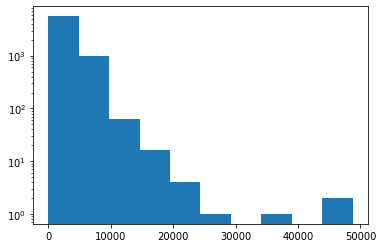

In [ ]:
plt.hist(pub_test["article_length"], log=True);

In [ ]:
pub_test.filter(lambda x: x["article_length"] > 10000).num_rows

  0%|          | 0/7 [00:00<?, ?ba/s]

84

In [ ]:
pub_test.filter(lambda x: x["article_length"] < 10000).num_rows

  0%|          | 0/7 [00:00<?, ?ba/s]

6574

Just to be precise evaluate tokenizers distribution and length.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6")

In [ ]:
max_input_length = 1024
max_target_length = 300


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["article"]
    )
    return model_inputs

In [ ]:
tok_pubtest = pub_test.map(preprocess_function, batched=True)

  0%|          | 0/7 [00:00<?, ?ba/s]

In [ ]:
def compute_tok_length(example):
    return {"n_tokens": len(example["input_ids"])}

In [ ]:
tok_pubtest = tok_pubtest.map(compute_tok_length)

In [ ]:
tok_pubtest.sort('n_tokens', reverse=True)[:10]['n_tokens']

[117407, 87547, 57596, 53422, 44366, 40112, 32726, 32701, 29184, 28862]

In [ ]:
tok_pubtest.sort('n_tokens', reverse=False)[:10]['n_tokens']

[28, 66, 66, 69, 79, 81, 97, 104, 109, 113]

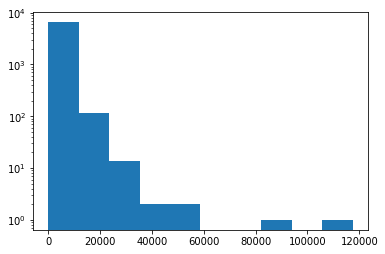

In [ ]:
plt.hist(tok_pubtest['n_tokens'], log=True);

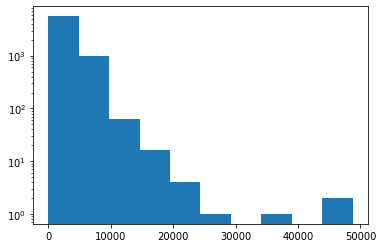

In [ ]:
plt.hist(pub_test["article_length"], log=True);

oc given that i truncate they are all the same length.

In [ ]:
%%timeit
gg=pub_test.map(lambda x: tokenizer(x['article'], max_length=1024, truncation=True), batched=True)

In [ ]:
#creating baseline
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])


print(three_sentence_summary(pubmed["train"][1]["article"]))

it occurs in more than 50% of patients and may reach 90% in certain types of cancers , especially in patients undergoing chemotherapy and/or radiation therapy.1 anemia is defined as an inadequate circulating level of hemoglobin ( hb ) ( hb < 12 g / dl ) and may arise as a result of the underlying disease , bleeding , poor nutrition , chemotherapy , or radiation therapy .
preliminary studies suggest that survival and loco - regional control after radiation therapy , especially in head and neck cancers , may be compromised by anemia.24 anemia often worsens symptoms such as fatigue , weakness , and dyspnea , and thus may have a negative effect on quality of life ( qol ) and performance status in patients with cancer .
thus , to improve physical functioning , qol , and prognosis in patients with cancer , it would be reasonable to take a proactive approach in identifying populations who need treatment for cancer - associated anemia ( caa ) and provide timely management .


In [ ]:
from datasets import load_metric

rouge_score = load_metric("rouge")

In [ ]:
generated_summary = three_sentence_summary(str('Diet modulates the gut microbiome, which in turn can impact the immune system. Here, we determined how two microbiota-targeted dietary interventions, plant-based fiber and fermented foods, influence the human microbiome and immune system in healthy adults. Using a 17-week randomized, prospective study (n = 18/arm) combined with -omics measurements of microbiome and host, including extensive immune profiling, we found diet-specific effects. The high-fiber diet increased microbiome-encoded glycan-degrading carbohydrate active enzymes (CAZymes) despite stable microbial community diversity. Although cytokine response score (primary outcome) was unchanged, three distinct immunological trajectories in high-fiber consumers corresponded to baseline microbiota diversity. Alternatively, the high-fermented-food diet steadily increased microbiota diversity and decreased inflammatory markers. The data highlight how coupling dietary interventions to deep and longitudinal immune and microbiome profiling can provide individualized and population-wide insight. Fermented foods may be valuable in countering the decreased microbiome diversity and increased inflammation pervasive in industrialized society.'))
reference_summary = "The foods you eat can change the bacteria in your body. These bacteria can help or hurt your immune system.The people who ate the most fermented foods had the most diverse kinds of bacteria and the lowest levels of inflammation." #extracted from tldr tweet

In [ ]:
#scores = rouge_score.compute(
    #predictions=[generated_summary], references=[reference_summary]
#)
#scores

In [ ]:
#scores["rougeLsum"].mid

Evaluate baseline for summarization.

In [ ]:
def evaluate_baseline(dataset, metric):
    summaries = [three_sentence_summary(text) for text in dataset['article']]
    return metric.compute(predictions=summaries, references=dataset['abstract'])

In [ ]:
import pandas as pd

score = evaluate_baseline(pubmed['test'], rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 26.7, 'rouge2': 8.83, 'rougeL': 16.7, 'rougeLsum': 24.11}

In [ ]:
#We can see that the rouge2 score is significantly lower than the rest; this likely reflects the fact that review titles are typically concise and so the lead-3 baseline is too verbose.

Evaluate zero shot summarization

distillbart cnn 12 6

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6")

model = AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-cnn-12-6")

In [ ]:
from transformers import pipeline
summarizer = pipeline("summarization", model='sshleifer/distilbart-cnn-12-6')
summ=summarizer(sequence, truncation=True, max_length=1024)

In [ ]:
sequence = pubmed['test'][1]['article']

In [ ]:
summ=summarizer(sequence, truncation=True, max_length=1024)

In [ ]:
def evaluate_zeroshot(dataset, metric):
    summaries = [summarizer(text, truncation=True, max_length=1024) for text in dataset['article']]
    return metric.compute(predictions=summaries, references=dataset['abstract'])

[{'summary_text': ' small non - coding small rna are transcribed into mrna but remain untranslated in eukaryotic cells . They regulate the stability or translational efficiency of targeted messenger rna . mirnas regulate gene expression and play important roles in the onset and progression of tumorigenesis . The understanding of how mirnas are involved in breast cancer through the cell cycle remains in the rudimentary understanding .'}]

In [ ]:
import pandas as pd

score = evaluate_baseline(pubmed['test'][1:50], rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 26.53, 'rouge2': 9.76, 'rougeL': 17.62, 'rougeLsum': 24.3}

In [ ]:
score = evaluate_zeroshot(pubmed['test'][1:50], rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

Your max_length is set to 1024, but you input_length is only 660. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=330)
Your max_length is set to 1024, but you input_length is only 460. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=230)
Your max_length is set to 1024, but you input_length is only 804. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=402)


{'rouge1': 25.44, 'rouge2': 8.95, 'rougeL': 16.44, 'rougeLsum': 21.74}

Just for 50 examples but worse than our baseline...

Try with fine tuned pegasus for arxiv (should be better)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("google/pegasus-arxiv")

model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-arxiv")

In [ ]:
del summarizer

In [ ]:
def evaluate_finetuned(dataset, metric):
    summaries = [summarizer(text, truncation=True, max_length=1024) for text in dataset['article']]
    return metric.compute(predictions=summaries, references=dataset['abstract'])

In [ ]:
import pandas as pd

score = evaluate_baseline(pubmed['test'][1:50], rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 26.53, 'rouge2': 9.76, 'rougeL': 17.62, 'rougeLsum': 24.3}

In [ ]:
score = evaluate_finetuned(pubmed['test'][1:50], rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

Your max_length is set to 1024, but you input_length is only 636. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=318)
Your max_length is set to 1024, but you input_length is only 435. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=217)
Your max_length is set to 1024, but you input_length is only 784. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=392)


{'rouge1': 33.87, 'rouge2': 13.24, 'rougeL': 20.34, 'rougeLsum': 28.45}

Running pegasus on cpu on all article takes too much time, either gpu or just give abstract and restrict it. Still rsults are significantly better despite super long inference.

Check how much only limiting to 1024 tokens is affecting analysis, another reason together with fact that there are sections that are not really relevant to directly summarize the abstract.

In [ ]:
pubmed["test"][1]["article"][0]

's'

In [ ]:
pubmed

DatasetDict({
    train: Dataset({
        features: ['article', 'abstract', 'section_names'],
        num_rows: 119924
    })
    validation: Dataset({
        features: ['article', 'abstract', 'section_names'],
        num_rows: 6633
    })
    test: Dataset({
        features: ['article', 'abstract', 'section_names'],
        num_rows: 6658
    })
})

In [ ]:
pm = pubmed.filter(lambda x: x["test"][1:10]["article"] > 1024)
print(pm.num_rows)

In [ ]:
import torch
if torch.backends.mps.is_available():
    device = torch.device("mps")
model.to(device)
tokens.to(device)
device

In [ ]:
print(torch.backends.mps.is_built())
# And that the current hardware and MacOS version are sufficient to
# be able to use MPS
print(torch.backends.mps.is_available())

True
True


In [ ]:
from transformers import pipeline
summarizer = pipeline("summarization", model='sshleifer/distilbart-cnn-12-6')

In [ ]:
%%timeit
summ=summarizer(sequence, truncation=True, max_length=1024) #with cpu

5.87 s ± 96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
scores = rouge_score.compute(
    predictions=[summ], references=[pubmed['test'][1]['abstract']]
)
scores

{'rouge1': AggregateScore(low=Score(precision=0.46774193548387094, recall=0.3258426966292135, fmeasure=0.38410596026490074), mid=Score(precision=0.46774193548387094, recall=0.3258426966292135, fmeasure=0.38410596026490074), high=Score(precision=0.46774193548387094, recall=0.3258426966292135, fmeasure=0.38410596026490074)),
 'rouge2': AggregateScore(low=Score(precision=0.14754098360655737, recall=0.10227272727272728, fmeasure=0.12080536912751677), mid=Score(precision=0.14754098360655737, recall=0.10227272727272728, fmeasure=0.12080536912751677), high=Score(precision=0.14754098360655737, recall=0.10227272727272728, fmeasure=0.12080536912751677)),
 'rougeL': AggregateScore(low=Score(precision=0.3387096774193548, recall=0.23595505617977527, fmeasure=0.27814569536423844), mid=Score(precision=0.3387096774193548, recall=0.23595505617977527, fmeasure=0.27814569536423844), high=Score(precision=0.3387096774193548, recall=0.23595505617977527, fmeasure=0.27814569536423844)),
 'rougeLsum': Aggregat

retest with bert to see what's optimal batch size for mac gpu

try to use pegasus on gpu mac

In [ ]:
from datasets import load_dataset  # pip install datasets

# load the first 1K rows of the TREC dataset
trec = load_dataset('trec', split='train[:1000]')
trec

Using custom data configuration default
Reusing dataset trec (/Users/lorenzogermini/.cache/huggingface/datasets/trec/default/1.1.0/751da1ab101b8d297a3d6e9c79ee9b0173ff94c4497b75677b59b61d5467a9b9)


Dataset({
    features: ['label-coarse', 'label-fine', 'text'],
    num_rows: 1000
})

In [ ]:
trec[0]

{'label-coarse': 0,
 'label-fine': 0,
 'text': 'How did serfdom develop in and then leave Russia ?'}

In [ ]:
print(f"Number of files in dataset : {pubmed['train'].dataset_size}")
size_gb = pubmed['train'].dataset_size / (1024**3)
print(f"Dataset size (cache file) : {size_gb:.2f} GB")

Number of files in dataset : 2506615061
Dataset size (cache file) : 2.33 GB


In [ ]:
print(f"Number of files in dataset : {trec.dataset_size}")
size_gb = trec.dataset_size / (1024**3)
print(f"Dataset size (cache file) : {size_gb:.2f} GB")

Number of files in dataset : 413065
Dataset size (cache file) : 0.00 GB


In [ ]:
from transformers import AutoTokenizer, AutoModel  # pip install transformers

# initialize BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

# take the first 64 rows of the trec data
text = trec['text'][:64]
# tokenize text using the BERT tokenizer
tokens = tokenizer(
    text, max_length=512,
    truncation=True, padding=True,
    return_tensors='pt'
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.to('cpu')
tokens.to('cpu')

In [ ]:
%%timeit
model(**tokens) #64 batch -> 376 on cpu

376 ms ± 5.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# take the first 64 rows of the trec data
text = trec['text'][:128]
# tokenize text using the BERT tokenizer
tokens = tokenizer(
    text, max_length=512,
    truncation=True, padding=True,
    return_tensors='pt'
)
model.to('cpu')
tokens.to('cpu')

In [ ]:
%%timeit
model(**tokens) #128 batch -> 942 ms on cpu

942 ms ± 27.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# take the first 64 rows of the trec data
text = trec['text'][:512]
# tokenize text using the BERT tokenizer
tokens = tokenizer(
    text, max_length=512,
    truncation=True, padding=True,
    return_tensors='pt'
)
model.to('cpu')
tokens.to('cpu')

In [ ]:
%%timeit
model(**tokens) #512 batch ->  7.71s +- 1.5 s on cpu

7.71 s ± 1.44 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# take the first 64 rows of the trec data
text = trec['text'][:128]
# tokenize text using the BERT tokenizer
tokens = tokenizer(
    text, max_length=512,
    truncation=True, padding=True,
    return_tensors='pt'
)
model.to('cpu')
tokens.to('cpu')

In [ ]:
model.to(device)
tokens.to(device)
device

device(type='mps')

In [ ]:
%%timeit
model(**tokens) #64 batch -> 173ms on gpu

173 ms ± 967 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
size_gb = trec[0].dataset_size / (1024**3)
print(f"Dataset size (cache file) : {size_gb:.2f} GB")

In [ ]:
# take the first 64 rows of the trec data
text = trec['text'][:128]
# tokenize text using the BERT tokenizer
tokens = tokenizer(
    text, max_length=512,
    truncation=True, padding=True,
    return_tensors='pt'
)

In [ ]:
tokens.to(device)

In [ ]:
%%timeit
model(**tokens) #128 batch -> 333ms + 20 ms

333 ms ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# take the first 64 rows of the trec data
text = trec['text'][:512]
# tokenize text using the BERT tokenizer
tokens = tokenizer(
    text, max_length=512,
    truncation=True, padding=True,
    return_tensors='pt'
)
model.to(device)
tokens.to(device)

In [ ]:
%%timeit
model(**tokens) #512 batch -> 21.2 s + 1.81

21.2 s ± 987 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
#first test what is optimal ba

In [ ]:
sequence = pubmed['test'][1]['article']

tokens = tokenizer(sequence, truncation=True, max_length=1024)
ids = tokenizer.convert_tokens_to_ids(tokens)
input_ids = torch.tensor([ids],device=device)

In [ ]:
output = model(input_ids)

In [ ]:
output.logits

/Users/lorenzogermini/miniforge3/envs/ml/lib/python3.9/site-packages/torch/_tensor_str.py:103: UserWarning: The operator 'aten::bitwise_and.Tensor_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(tensor_view, torch.isfinite(tensor_view) & tensor_view.ne(0))


tensor([[[ 6.8322, -1.1086,  6.5042,  ..., -1.7876, -2.0605, -1.5786],
         [ 6.8303, -1.1086,  6.5041,  ..., -1.7877, -2.0606, -1.5785]]],
       device='mps:0', grad_fn=<AddBackward0>)

In [ ]:
predictions = torch.nn.functional.softmax(output.logits, dim=-1)
print(predictions)

tensor([[[4.5539e-04, 1.6208e-07, 3.2806e-04,  ..., 8.2196e-08,
          6.2563e-08, 1.0130e-07],
         [4.5451e-04, 1.6207e-07, 3.2801e-04,  ..., 8.2188e-08,
          6.2558e-08, 1.0131e-07]]], device='mps:0',
       grad_fn=<SoftmaxBackward0>)


In [ ]:
model.config.id2label

{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2'}

In [ ]:
inputs = tokenizer(art, truncation=True, max_length=1024, return_tensors="pt").to(device)
model.to(device)

# Generate Summary
summary_ids = model.generate(inputs["input_ids"])
#tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

In [ ]:
output = model.generate(input_ids, max_length=20)
predictions = tokenizer.batch_decode(output, skip_special_tokens=True)

inputs = tokenizer([ARTICLE_TO_SUMMARIZE], max_length=1024, return_tensors="pt")

# Generate Summary
summary_ids = model.generate(inputs["input_ids"], num_beams=2, min_length=0, max_length=20)
tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

In [ ]:
input_ids= 

In [ ]:
sequence = pubmed['test'][1]['article']

inpua

tokens = tokenizer(sequence, truncation=True, max_length=1024)
ids = tokenizer.convert_tokens_to_ids(tokens)
input_ids = torch.tensor([ids],device=device)
#input_ids.to(device)
# This line will fail.

In [ ]:
input

In [ ]:
model.to(device)

In [ ]:
output= model(input_ids)

In [ ]:
output

In [ ]:
predictions = tokenizer.batch_decode(output, skip_special_tokens=True)

In [ ]:
output=model.generate(input_ids, max_length=300)

In [ ]:
art = pubmed['test'][1]['article']

input_ids = tokenizer(art, max_length=1024, truncation=True, padding='longest', return_tensors="pt").to(device)

In [ ]:
summary_ids = model.generate(inputs["input_ids"], num_beams=2, min_length=0, max_length=20)

In [ ]:
model.to(device)

In [ ]:
sequence = pubmed['test'][1]['article']

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)
input_ids = torch.tensor([ids])
input_ids.to(device)
# This line will fail.

tensor([[23115,   786,   111,  ...,  1668,  1484,   479]], device='mps:0')

In [ ]:
output=model.generate(input_ids, max_length=300) #model.generate fails